In [2]:
# data manipulation and analysis
import pandas as pd # data manipulation and analysis (reading CSV, DataFrame operations)
import re

# machine learning components
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gdown

In [3]:
# download the dataset
file_url = 'https://drive.google.com/uc?id=1tRQwBZAbEEdeO3OY0aEJ9hl2a25Z4PCA'
dataset_file = 'spam_emails_data.csv'

if not os.path.exists(dataset_file):
    print("File not found. Downloading now...")
    gdown.download(file_url, dataset_file, quiet=False)
else:
    print("File already exists.")

File already exists.


**Imports essential libraries**

**Load dataset**

In [4]:
# data = "/content/drive/MyDrive/DATASETS/spam_emails_data.csv"
df = pd.read_csv('spam_emails_data.csv')

**Initial Data Exploration**

In [5]:
# view dimensions of dataset

df.shape

(193852, 2)

*Dataset has 193,852 rows and 2 columns*

In [27]:
# preview the dataset

df.head()

,label,text,cleaned_text
0,1,viiiiiiagraaaa\nonly for the ones that want to...,viiiiiiagraaaa only for the ones that want to ...
1,0,got ice thought look az original message ice o...,got ice thought look az original message ice o...
2,1,yo ur wom an ne eds an escapenumber in ch ma n...,yo ur wom an ne eds an escapenumber in ch ma n...
3,1,start increasing your odds of success & live s...,start increasing your odds of success live sex...
4,0,author jra date escapenumber escapenumber esca...,author jra date escapenumber escapenumber esca...


In [ ]:
# get unique values for label columns

df['label'].value_counts()

label
Ham     102160
Spam     91692
Name: count, dtype: int64

In [8]:
# view summary of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [ ]:
# check for missing values

df.isnull().sum()

,0
label,0
text,2


*0 missing values for 'label' and 2 missing values for 'text'*

In [ ]:
# check for duplicate rows

df.duplicated().sum()

np.int64(0)

**Data Cleaning**

*Removes the 2 rows identified with missing values to ensure data integrity for processing*

In [10]:
# delete rows with missing values

df.dropna(inplace=True)

**Exploratory Data Analysis (EDA)**

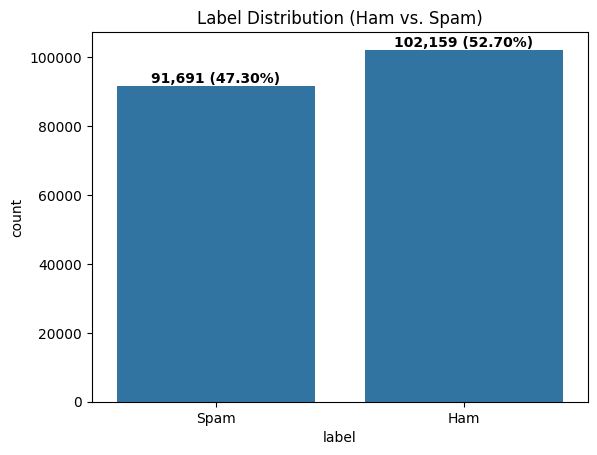

In [11]:
# class distribution analysis (count and percentage)
ax = sns.countplot(data=df, x='label')
plt.title("Label Distribution (Ham vs. Spam)")

total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(f'{count:,} ({percent:.2f}%)',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.show()

*The plot shows that Spam constitutes 47.30% (91,691 emails) and Ham constitutes 52.70% (102,159 emails) of the dataset after cleaning*

**Data Preprocessing**

*The preprocess_text function cleans the email text data:*
*   *Removes non-alphanumeric characters*
*   *Converts text to lowercase*
*   *Removes extra whitespace and stripping leading/trailing whitespace*

*The preprocess_text function is applied to the 'text' column and stores the result in a new column - 'cleaned_text'*

*LabelEncoder transforms the categorical 'label' column ('Ham', 'Spam') into numerical values (0 for 'Ham', 1 for 'Spam'). The original 'label' column is overwritten with these numerical labels*

In [16]:
def preprocess_text(text):
    """Clean and standardize email text"""
    text = re.sub(r'\W', ' ', str(text))  # remove non-alphanumeric
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

# apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# encode labels (Ham:0, Spam:1)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [18]:
df.head()

,label,text,cleaned_text
0,1,viiiiiiagraaaa\nonly for the ones that want to...,viiiiiiagraaaa only for the ones that want to ...
1,0,got ice thought look az original message ice o...,got ice thought look az original message ice o...
2,1,yo ur wom an ne eds an escapenumber in ch ma n...,yo ur wom an ne eds an escapenumber in ch ma n...
3,1,start increasing your odds of success & live s...,start increasing your odds of success live sex...
4,0,author jra date escapenumber escapenumber esca...,author jra date escapenumber escapenumber esca...


**Feature Engineering & Data Splitting**

*Dataset is separated into features X (the 'cleaned_text' column) and the target variable y (the numerically encoded 'label' column)*

*train_test_split method used to divide the data into training (80%) and testing (20%) sets. random_state=42 ensures reproducibility, and stratify=y maintains the original proportion of 'Ham' and 'Spam' labels in both sets*

*TfidfVectorizer converts the text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency) method:*
* *max_features=5000: Limits the vocabulary to the top 5000 most frequent terms*
* *stop_words='english': Removes common English stop words*

*Fits the vectorizer on the training text (X_train) and transforms both X_train and X_test into TF-IDF matrices (X_train_tfidf, X_test_tfidf)*

In [17]:
# Split data into features and target
X = df['cleaned_text']
y = df['label']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**Model Training**

*Initializes the Logistic Regression classifier and trains it using the TF-IDF features from the training set (X_train_tfidf) and the corresponding training labels (y_train).*
*   *max_iter=1000: Increases the maximum number of iterations allowed for the solver to converge, which can be helpful for larger datasets.*
*   *random_state=42: Ensures reproducibility of the results.*

In [19]:
# Initialize and train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

**Visualization of Logistic Regression Outputs**

*Calculates the linear output z (log-odds/logit) for each sample in the training set using the trained model's decision_function() method on the training TF-IDF features (X_train_tfidf)*


In [21]:
z = model.decision_function(X_train_tfidf)
z

array([ 1.84725522,  1.22914531, -7.96937111, ...,  3.73380246,
        5.59539606,  8.16750985], shape=(155080,))

**Linear Output**

*Creates a scatter plot of these z values against the sample index, coloring the points based on their actual class (y_train). A horizontal dashed line is added at z=0, representing the decision boundary before the sigmoid transformation*

*Creates a scatter plot visualizing the linear separability of the training data. Points (red) above the z=0 line are more likely to be classified as Spam (1), and those (blue) below as Ham (0), based on the linear model*

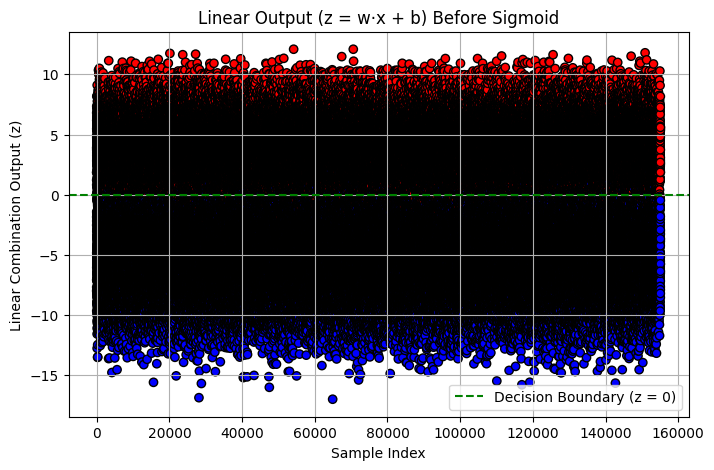

In [22]:
# Plot linear output z = w·x + b
plt.figure(figsize=(8, 5))
plt.scatter(range(len(z)), z, c=y_train, cmap='bwr', edgecolor='k')
plt.axhline(0, color='green', linestyle='--', label='Decision Boundary (z = 0)')
plt.title("Linear Output (z = w·x + b) Before Sigmoid")
plt.xlabel("Sample Index")
plt.ylabel("Linear Combination Output (z)")
plt.grid(True)
plt.legend()
plt.show()

*Calculates the predicted probabilities prob (output of the sigmoid function) for the training set using the trained model's predict_proba() method and selecting the probability for the positive class (Spam, typically class 1). It then plots these probabilities (prob) against the corresponding linear outputs (z calculated in the previous cell), effectively visualizing the sigmoid curve as fitted to this specific dataset. A horizontal dashed line at probability 0.5 represents the classification threshold.*

In [24]:
prob = model.predict_proba(X_train_tfidf)[:, 1]
prob

array([8.63804512e-01, 7.73668949e-01, 3.45776844e-04, ...,
       9.76656181e-01, 9.96298822e-01, 9.99716357e-01], shape=(155080,))

**Sigmoid Curve**  

In this example we are using regression to predict whether 1-> an email is SPAM and 0-> an email is not SPAM, It would be more useful if the regression model predicted a formal probability i.e. values between 0 and 1 (not just 1 or 0 only) representing the chances that for instance an email is “SPAM” will then be based on a higher values nearing 1, or that the likelihood of an email being classified as “NOT SPAM” will increase as we get closer to 0.  

This type of regression task is called logistic regression. To transition a linear model to output a probability, we need to transform the model to apply some limits so that it outputs continuous  values that fall within the range between 0 and 1 where 0 indicates a zero chance that an email is SPAM and 1 indicates 100 %  chance that an email is SPAM, if a model outputs something like 0.85 we can safely interest that there is an  85% chance that the email is SPAM.

The mathematical functions that we can apply to do this are by combining an exponential curve and hyperbola curve formulae  because both approach a limit in at least one direction, when combined they are now restrained to output values between 0 and 1, and from this exercise we come up with the sigmoid curve. In other words we apply a transformation to the output of a linear model using a mathematical function called the sigmoid function. The sigmoid is shaped like an "S", and it combines aspects of exponential and hyperbolic curves. The important thing to note here once again is that it squeezes any real number input (positive or negative) into a range between 0 and 1 which works well for representing probabilities.

This statistical model uses a logistic (sigmoid) function to model the probability that a given input belongs to a particular class.

Always remember that a  logistic regression model uses a linear model, but packages the output in a sigmoid function so that we get probabilities, not just raw numbers. This helps us model the likelihood that any given input like an email belongs to a certain class (spam or not spam).

*A scatter plot showing the characteristic 'S' shape of the sigmoid function, mapping the linear outputs (z) to probabilities between 0 and 1*

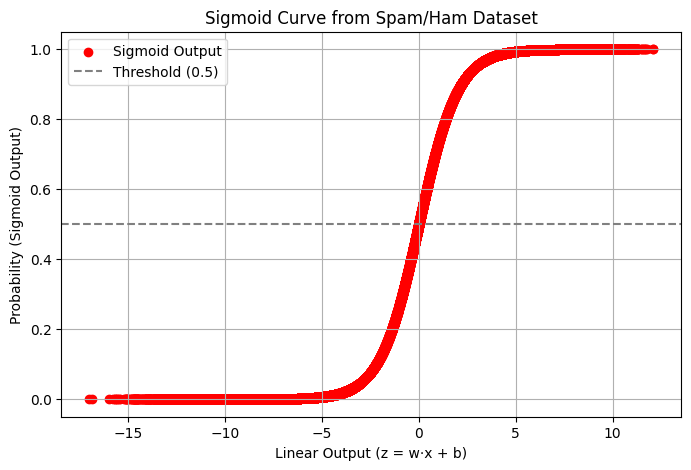

In [25]:
# Plot sigmoid probabilities against z
plt.figure(figsize=(8, 5))
plt.scatter(z, prob, color='red', label='Sigmoid Output')
plt.axhline(0.5, color='grey', linestyle='--', label='Threshold (0.5)')
plt.title("Sigmoid Curve from Spam/Ham Dataset")
plt.xlabel("Linear Output (z = w·x + b)")
plt.ylabel("Probability (Sigmoid Output)")
plt.grid(True)
plt.legend()
plt.show()

**Hyperparameters Tuning**

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

def train_sgd_and_track_loss(n_epochs=100, max_iter=1, learning_rate='constant', eta0=0.01):
    """
    Trains an SGDClassifier for multiple epochs, tracking log loss on each pass.

    Args:
        n_epochs (int): Number of full training cycles (passes over the dataset).
        max_iter (int): Number of internal iterations per .fit() call (usually 1 for manual epoch control).
        learning_rate (str): Strategy for updating the learning rate.
                             Options: 'constant', 'optimal', 'invscaling', 'adaptive'.
        eta0 (float): Initial learning rate (step size) when learning_rate='constant' or 'invscaling'.

    The function uses 'log_loss' (logistic loss) for binary classification, making it suitable
    for probabilistic outputs like in a Spam vs. Ham email classification task.
    """

    # Using 'log_loss' (logistic regression loss) for binary classification with probability output
    sgd = SGDClassifier(loss='log_loss', max_iter=max_iter, learning_rate=learning_rate, eta0=eta0, warm_start=True)

    losses = []

    for epoch in range(n_epochs):
        sgd.fit(X_train_tfidf, y_train)
        prob = sgd.predict_proba(X_train_tfidf)
        loss = log_loss(y_train, prob)
        losses.append(loss)

    # Plot the loss over training epochs
    plt.plot(range(n_epochs), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.title("Log Loss over Epochs (Gradient Descent)")
    plt.grid(True)
    plt.show()


/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3

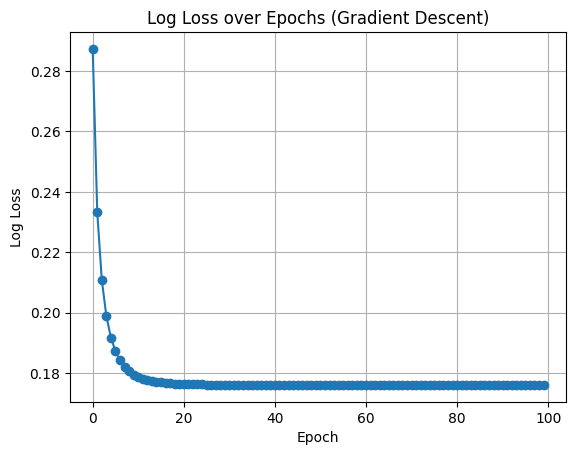

In [29]:
# Baseline configuration: steady training to observe general behavior over epochs.
# Uses a constant learning rate with small initial step size.
# Settings: n_epochs=100, max_iter=1, learning_rate='constant', eta0=0.01
train_sgd_and_track_loss()

/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3

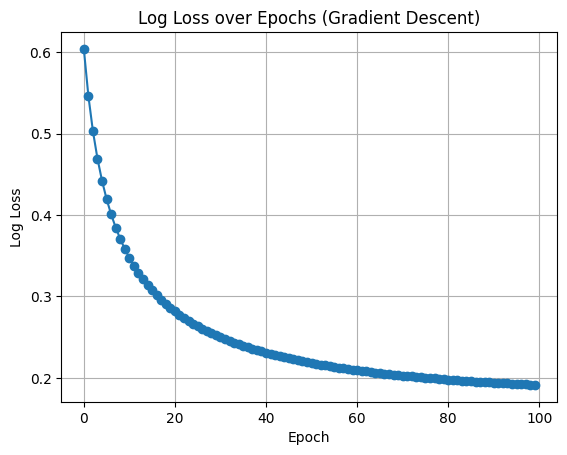

In [30]:
# Smooth Decay - Gradual decay helps with large gradients
train_sgd_and_track_loss(n_epochs=100, max_iter=1, learning_rate='invscaling', eta0=0.1)

/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mulombi/.local/lib/python3

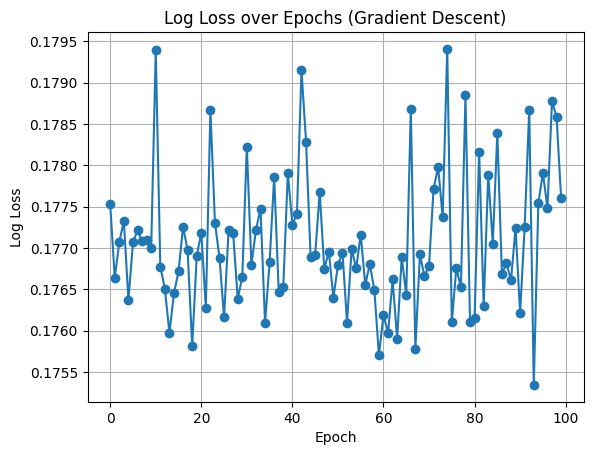

In [31]:
# Aggressive Learning - High constant LR (0.5) causes oscillation/instability
train_sgd_and_track_loss(n_epochs=100, max_iter=1, learning_rate='constant', eta0=0.5)

In [26]:
# Cross-validation
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Test set evaluation
y_pred = model.predict(X_test_tfidf)

# Performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")


Cross-Validation Accuracy: 0.9721 (±0.0008)

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.97     20432
        Spam       0.97      0.97      0.97     18338

    accuracy                           0.97     38770
   macro avg       0.97      0.97      0.97     38770
weighted avg       0.97      0.97      0.97     38770


Confusion Matrix:
[[19792   640]
 [  504 17834]]

ROC AUC Score: 0.9706
